In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
from fastai.tabular import *

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [4]:
def create_feautures(df):
    df_new = df.copy()
    Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona":"Dona",
    }

    
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())

    # a map of more aggregated title
    # we map each title
    df_new['Title'] = df.Title.map(Title_Dictionary)
    
    df_new['Cabin'] = df.Cabin.apply(lambda cabin: cabin[0] if not cabin != cabin else 'N')
    
    grouped_train = df_new.groupby(['Sex','Pclass','Title'])
    grouped_median_train = grouped_train.median()
    grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
    
    def fill_age(row):
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Title'] == row['Title']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        ) 
        return grouped_median_train[condition]['Age'].values[0]
    # a function that fills the missing values of the Age variable
    df_new['Age'] = df_new.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    df_new.Age = df_new.Age.fillna(df_new.Age.mean())
    
    
    df_new['Embarked'] = df_new.Embarked.fillna('S')
    
    #Fares 
    df_new['Fare'] = df_new.Fare.fillna(df.Fare.median())
    
    df_new.drop(["PassengerId","Name", "Ticket"], axis=1, inplace=True)
    #df_new.drop(["Name", "Ticket"], axis=1, inplace=True)
        
    
    return df_new

train_df_new = create_feautures(train_df)
test_df_new = create_feautures(test_df)
print(train_df_new.head())
print(test_df_new.head())

   Survived  Pclass     Sex   Age  ...      Fare  Cabin  Embarked Title
0         0       3    male  22.0  ...    7.2500      N         S    Mr
1         1       1  female  38.0  ...   71.2833      C         C   Mrs
2         1       3  female  26.0  ...    7.9250      N         S  Miss
3         1       1  female  35.0  ...   53.1000      C         S   Mrs
4         0       3    male  35.0  ...    8.0500      N         S    Mr

[5 rows x 10 columns]
   Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked Title
0       3    male  34.5      0      0   7.8292     N        Q    Mr
1       3  female  47.0      1      0   7.0000     N        S   Mrs
2       2    male  62.0      0      0   9.6875     N        Q    Mr
3       3    male  27.0      0      0   8.6625     N        S    Mr
4       3  female  22.0      1      1  12.2875     N        S   Mrs


In [5]:

procs = [FillMissing, Categorify, Normalize]
cat_names = ['Pclass','Sex', 'Title', 'SibSp', 'Parch','Embarked','Cabin']
cont_names = ['Age', 'Fare']
dep_var = 'Survived'

data = (TabularList.from_df(train_df_new, procs=procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx=range(int(len(train_df_new)*0.9),len(train_df_new)))
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(test_df_new, cat_names=cat_names, cont_names=cont_names, procs=procs))
        .databunch())
print(data.train_ds.cont_names)
print(data.train_ds.cat_names)

['Age', 'Fare']
['Pclass', 'Sex', 'Title', 'SibSp', 'Parch', 'Embarked', 'Cabin']


In [6]:
learn = tabular_learner(data, layers=[1000,500], metrics=accuracy)

In [7]:
learn.fit_one_cycle(2, 2.5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.651376,0.547687,0.711111
2,0.585482,0.606865,0.744444


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03


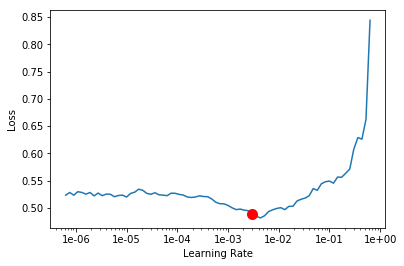

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.509735,0.544460,0.777778
2,0.481761,0.433364,0.822222
3,0.449960,0.360404,0.855556
4,0.430525,0.340080,0.866667
5,0.417570,0.343467,0.855556
6,0.405581,0.336221,0.855556
7,0.399952,0.333464,0.877778
8,0.394990,0.331255,0.844444
9,0.388227,0.326258,0.833333
10,0.383882,0.326593,0.855556


In [10]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
pred_prob, pred_class = preds.max(1)

submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':pred_class})

In [11]:
submission.to_csv('submission-fastai.csv', index=False)

In [12]:
!kaggle competitions submit -c titanic -f submission-fastai.csv -m "Fastai"

/bin/sh: 1: kaggle: not found
